# Interval Pruning of Random Forest

This notebook demonstrates how to use the interval pruning to prune a random forest model by removing trees lying outside of a specified confidence interval.

<div class="alert alert-block alert-info">
<b>Example:</b> a 50% CI retains only the central 50% of the data, effectively removing the tails of the tree predictions' distribution (25% on each side). In this notebook we show how it can be useful for reducing the size of the model without significantly affecting the performance.

</div>

Author: https://www.github.com/deburky

In [1]:
import copy
import warnings

import numpy as np
import pandas as pd
from scipy.stats import binom
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

def binomial_confidence_interval(model, X, confidence=0.95):
    """
    Compute exact binomial confidence intervals for classification.
    
    Parameters:
        model: Trained RandomForestClassifier.
        X: Feature matrix (n_samples, n_features).
        confidence: Confidence level (default 0.95).
    
    Returns:
        mean_prediction: Mean predicted probability for the positive class.
        lower_bound: Lower bound of the confidence interval.
        upper_bound: Upper bound of the confidence interval.
    """
    # Get predictions from each tree (as 0/1 outputs) or probabilities
    tree_predictions = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])
    
    # Calculate number of trees (trials) and number of successes for each observation
    n_trees = tree_predictions.shape[0]
    successes = tree_predictions.sum(axis=0)  # Number of 1's (positive class predictions) for each observation
    
    # Initialize lists to store bounds and mean predictions
    lower_bound = []
    upper_bound = []
    mean_prediction = successes / n_trees  # Proportion of successes (mean probability)

    # Confidence bounds for each observation
    for s in successes:
        # Compute lower and upper bounds using the Clopper-Pearson method
        lb = binom.ppf((1 - confidence) / 2, n_trees, s / n_trees) / n_trees
        ub = binom.ppf((1 + confidence) / 2, n_trees, s / n_trees) / n_trees
        lower_bound.append(lb)
        upper_bound.append(ub)
    
    return mean_prediction, np.array(lower_bound), np.array(upper_bound)

def prune_random_forest(model, X, lower_bound, upper_bound):
    """
    Prune trees directly from the Random Forest ensemble based on confidence intervals.

    Parameters:
        model: Trained RandomForestClassifier.
        X: Feature matrix (n_samples, n_features).
        lower_bound: Lower bound of the confidence interval.
        upper_bound: Upper bound of the confidence interval.

    Returns:
        model: The original RandomForestClassifier with pruned trees.
    """
    model_copy = copy.deepcopy(model)
    # Get predicted probabilities for each tree
    tree_probabilities = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])

    # # Calculate the mean prediction for each tree
    tree_means = tree_probabilities.mean(axis=1)

    # # Identify trees that fall within the confidence interval
    keep_indices = (tree_means >= lower_bound) & (tree_means <= upper_bound)

    # Prune the ensemble by keeping only the trees within the interval
    model_copy.estimators_ = [tree for keep, tree in zip(keep_indices, model_copy.estimators_) if keep]
    model_copy.n_estimators = len(model_copy.estimators_)

    return model_copy

# Load the dataset
X, y = make_classification(
    n_samples=8_000, n_features=15, n_informative=1, n_redundant=0, n_clusters_per_class=1, random_state=42,
    weights=[0.9, 0.1]
)

X, y = pd.DataFrame(X, columns=[f"Feature {i}" for i in range(X.shape[1])]), pd.Series(y, name="Target")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

# Calculate the mean predicted probabilities and confidence intervals
mean_binom, lower_binom, upper_binom = binomial_confidence_interval(rf, X_test)

# Apply pruning
mean_prediction, lower_bound, upper_bound = binomial_confidence_interval(rf, X_train, confidence=0.5)
pruned_rf = prune_random_forest(rf, X_train, lower_bound.mean(), upper_bound.mean())

In [2]:
# Evaluate pruned Random Forest
from sklearn.metrics import (
    brier_score_loss, log_loss, roc_auc_score
)

# Predictions from the original and pruned models
original_probas = rf.predict_proba(X_test)
pruned_probas = pruned_rf.predict_proba(X_test)

# Compare performance
original_log_loss = log_loss(y_test, original_probas)
pruned_log_loss = log_loss(y_test, pruned_probas)

original_brier = brier_score_loss(y_test, original_probas[:, 1])
pruned_brier = brier_score_loss(y_test, pruned_probas[:, 1])

original_auc = roc_auc_score(y_test, original_probas[:, 1])
pruned_auc = roc_auc_score(y_test, pruned_probas[:, 1])

# Print results
print("Performance Metrics")
print('-------------------')
print(f"Original RF Brier Score: {original_brier:.4f}")
print(f"Pruned RF Brier Score: {pruned_brier:.4f}")
print('-------------------')
print(f"Original RF AUC: {original_auc:.4f}")
print(f"Pruned RF AUC: {pruned_auc:.4f}")
print('-------------------')
print(f"Original RF Log Loss: {original_log_loss:.4f}")
print(f"Pruned RF Log Loss: {pruned_log_loss:.4f}")
print('-------------------')

# Calculate trees kept
original_n_trees = len(rf.estimators_)
pruned_n_trees = len(pruned_rf.estimators_)
print(f"Original RF Trees: {original_n_trees}")
print(f"Pruned RF Trees: {pruned_n_trees}")

Performance Metrics
-------------------
Original RF Brier Score: 0.0182
Pruned RF Brier Score: 0.0181
-------------------
Original RF AUC: 0.9680
Pruned RF AUC: 0.9683
-------------------
Original RF Log Loss: 0.0803
Pruned RF Log Loss: 0.0796
-------------------
Original RF Trees: 1000
Pruned RF Trees: 623


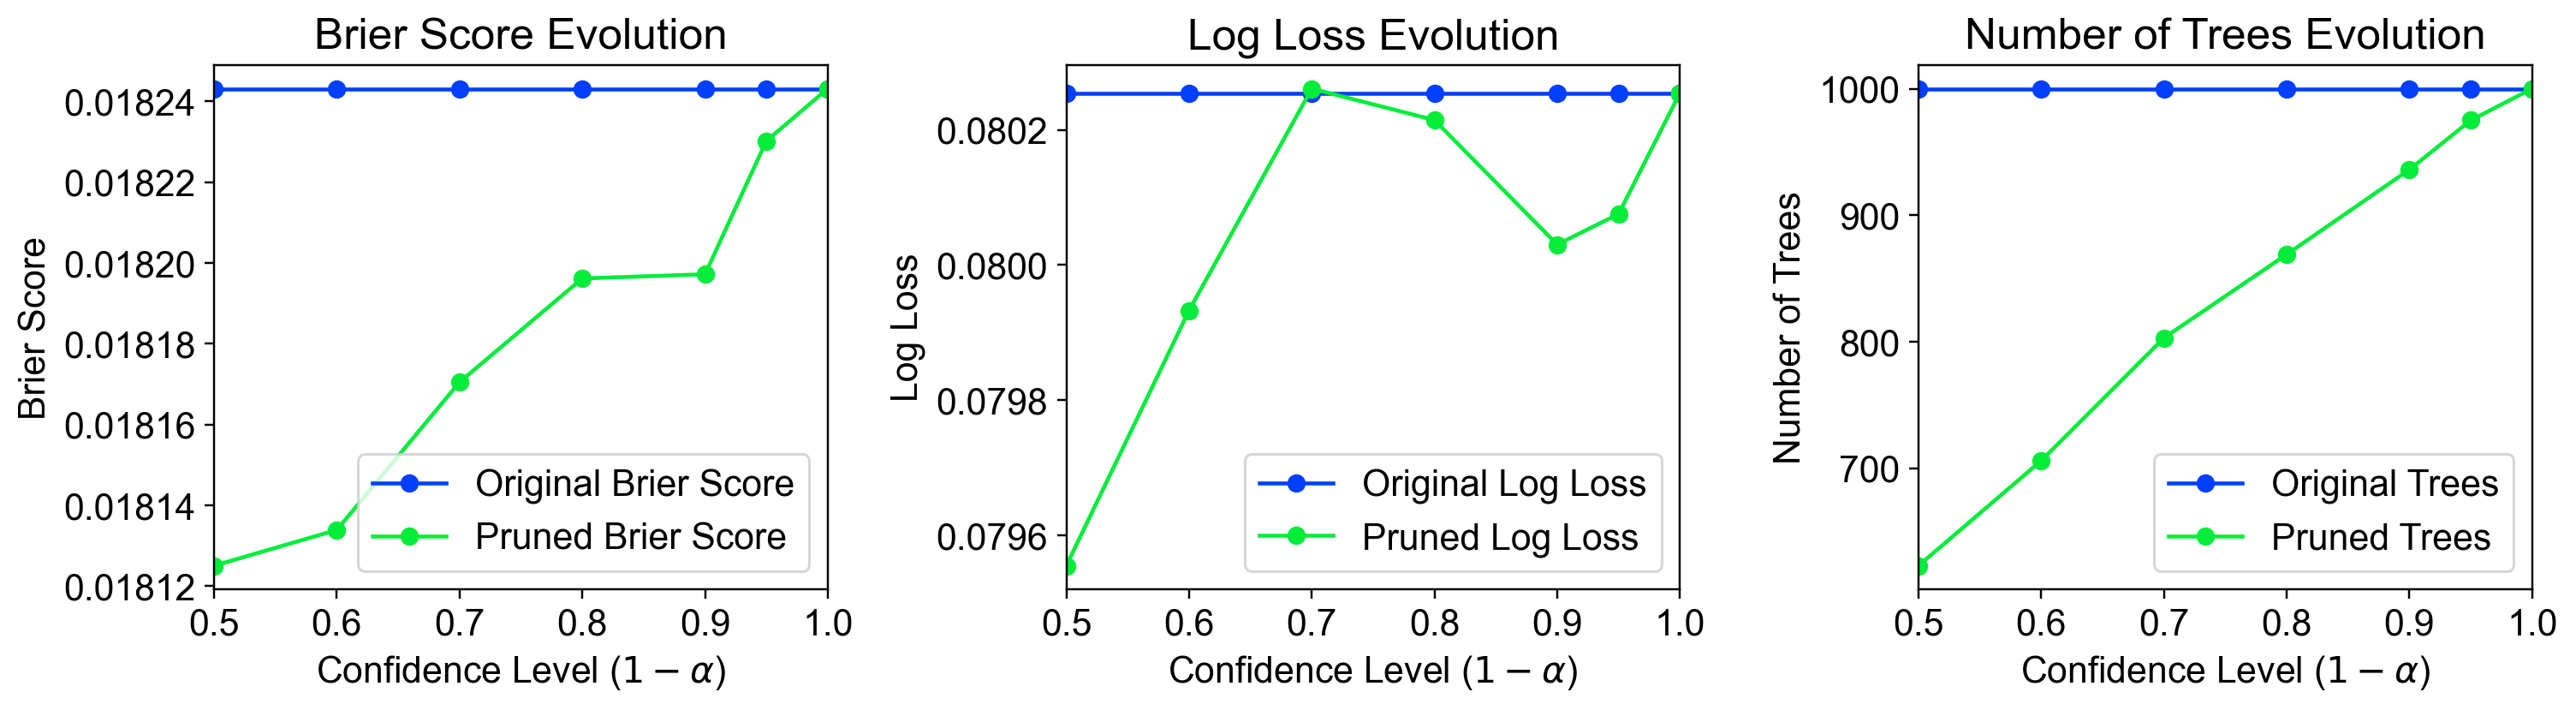

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    brier_score_loss, log_loss
)
%config InlineBackend.figure_format = 'retina'

# use style of plt
plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 14})

# Define different confidence levels to evaluate
confidence_levels = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]

# Initialize lists to store metrics for each confidence level
original_brier_list, pruned_brier_list = [], []
original_log_loss_list, pruned_log_loss_list = [], []
original_accuracy_list, pruned_accuracy_list = [], []
pruned_trees_list = []

for confidence in confidence_levels:
    # Calculate confidence intervals
    mean_prediction, lower_bound, upper_bound = binomial_confidence_interval(rf, X_train, confidence=confidence)

    # Prune the Random Forest
    pruned_rf = prune_random_forest(rf, X_train, lower_bound.mean(), upper_bound.mean())

    # Predictions for pruned model
    original_preds = rf.predict(X_test)
    pruned_preds = pruned_rf.predict(X_test)

    original_probas = rf.predict_proba(X_test)
    pruned_probas = pruned_rf.predict_proba(X_test)

    original_log_loss = log_loss(y_test, original_probas)
    pruned_log_loss = log_loss(y_test, pruned_probas)

    original_brier = brier_score_loss(y_test, original_probas[:, 1])
    pruned_brier = brier_score_loss(y_test, pruned_probas[:, 1])

    # Store metrics
    original_brier_list.append(original_brier)
    pruned_brier_list.append(pruned_brier)

    original_log_loss_list.append(original_log_loss)
    pruned_log_loss_list.append(pruned_log_loss)

    pruned_trees_list.append(len(pruned_rf.estimators_))

# Plot metrics evolution
plt.figure(figsize=(14, 7), dpi=110)

color_original = 'red'

# Plot Brier Score
plt.subplot(2, 3, 1)
plt.plot(confidence_levels, original_brier_list, label="Original Brier Score", marker='o')
plt.plot(confidence_levels, pruned_brier_list, label="Pruned Brier Score", marker='o')
plt.xlabel("Confidence Level ($1 - \\alpha$)")
plt.ylabel("Brier Score")
plt.title("Brier Score Evolution")
plt.legend()
plt.xlim(0.5, 1.0)

# Plot Log Loss
plt.subplot(2, 3, 2)
plt.plot(confidence_levels, original_log_loss_list, label="Original Log Loss", marker='o')
plt.plot(confidence_levels, pruned_log_loss_list, label="Pruned Log Loss", marker='o')
plt.xlabel("Confidence Level ($1 - \\alpha$)")
plt.ylabel("Log Loss")
plt.title("Log Loss Evolution")
plt.legend()
plt.xlim(0.5, 1.0)

# Plot Number of Trees
plt.subplot(2, 3, 3)
plt.plot(confidence_levels, [len(rf.estimators_)] * len(confidence_levels), label="Original Trees", marker='o')
plt.plot(confidence_levels, pruned_trees_list, label="Pruned Trees", marker='o')
plt.xlabel("Confidence Level ($1 - \\alpha$)")
plt.ylabel("Number of Trees")
plt.title("Number of Trees Evolution")
plt.xlim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## Visualize the effect of interval pruning

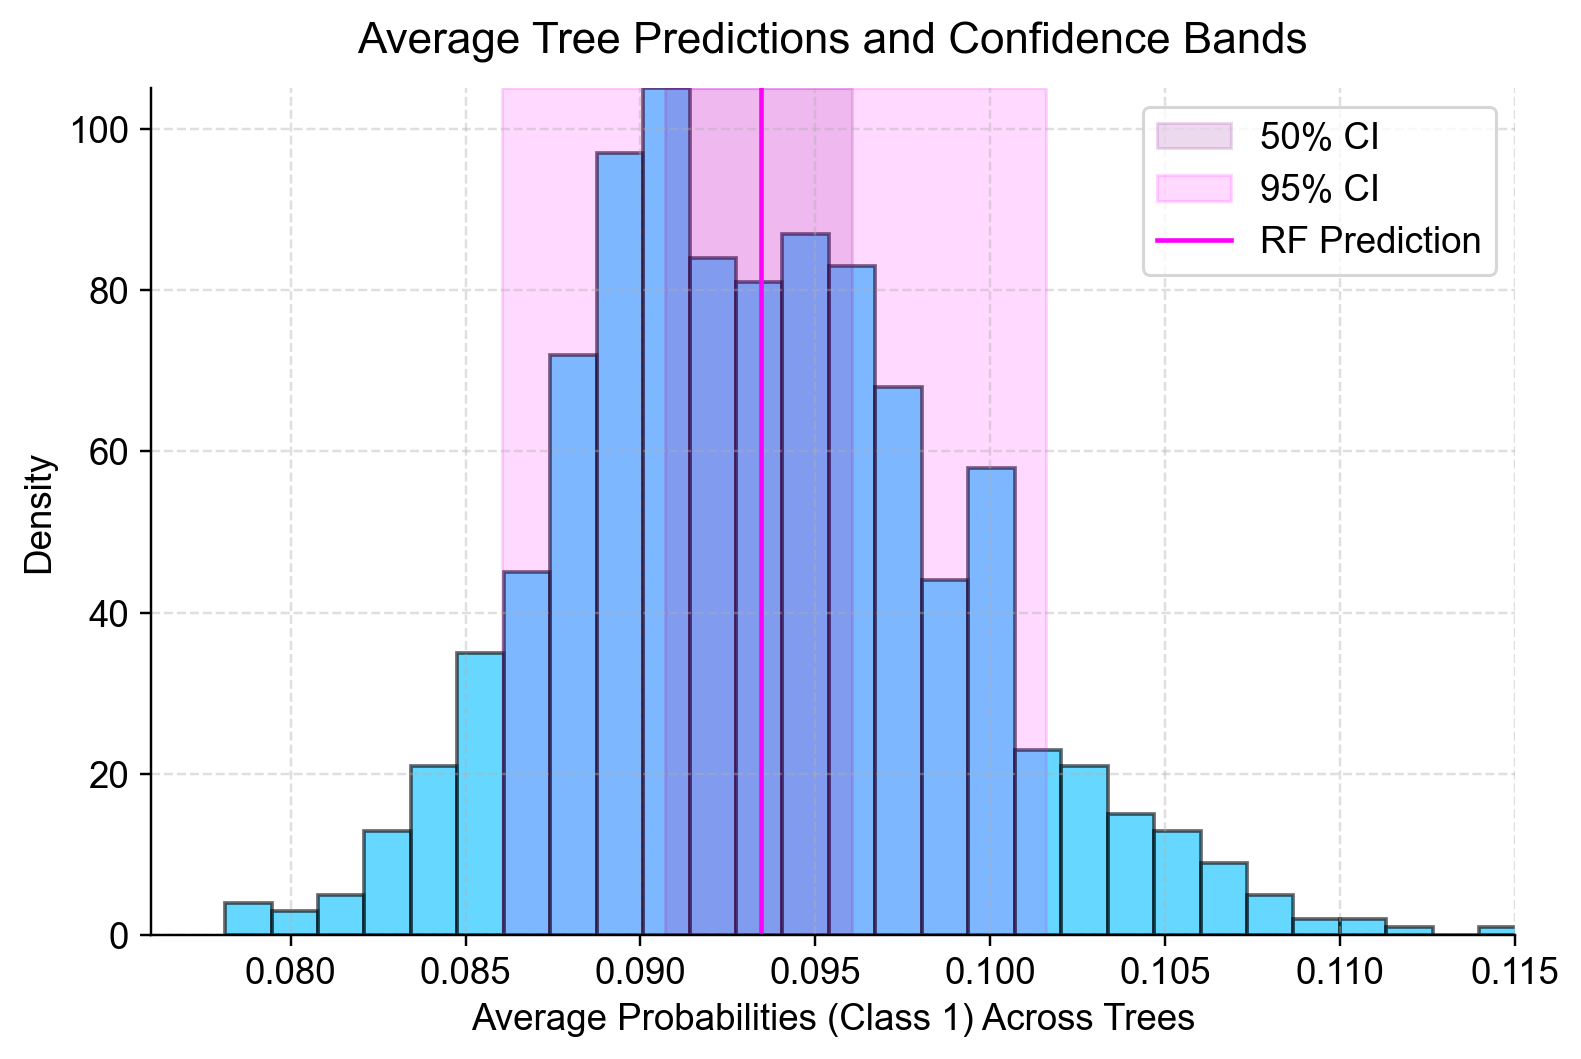

In [48]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

# Set fontsize to 14
plt.rcParams.update({'font.size': 12})

# Get predictions from each tree for the test set
tree_predictions = np.array([tree.predict_proba(X_test)[:, 1] for tree in rf.estimators_])

# Calculate the number of "successes" for each observation (sum of probabilities across trees)
successes = tree_predictions.mean(axis=1)

# Define confidence levels
confidence_levels = [0.5, 0.95]

# Initialize a dictionary to store confidence intervals
confidence_intervals = {}

# Compute confidence intervals for different confidence levels
n_trees = tree_predictions.shape[0]  # Total number of trees
for confidence in confidence_levels:
    mean_prediction, lower_bound, upper_bound = binomial_confidence_interval(rf, X_test, confidence=confidence)
    confidence_intervals[confidence] = (lower_bound, upper_bound)

# Plot histogram of successes
plt.figure(figsize=(8, 5), dpi=110)
hist_data, bins, _ = plt.hist(
    successes, bins='sqrt', density=False, alpha=0.6, color='deepskyblue', edgecolor='black', linewidth=1.2
)
max_density = hist_data.max()

# Overlay confidence intervals
for confidence, (lower_bound, upper_bound) in confidence_intervals.items():
    color = "magenta" if confidence == 0.95 else "darkmagenta"
    # Highlight the shared area
    plt.fill_betweenx(
        [0, max_density],
        lower_bound.mean(),
        upper_bound.mean(),
        color=color,
        label=f"{confidence:.0%} CI",
        alpha=0.15
    )
plt.axvline(successes.mean(), color='magenta', linewidth=1.5, label='RF Prediction')
plt.ylim(0, max_density)
plt.xlim(0.076, 0.115)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Average Tree Predictions and Confidence Bands", y=1.02)
plt.xlabel("Average Probabilities (Class 1) Across Trees")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.4, which='major', linestyle='--')
plt.show()